In [2]:
# カレントディレクトリをリポジトリ直下にするおまじない
# import os
# while os.getcwd().split('/')[-1] != 'deep_dialog_tutorial': os.chdir('..')
# print('current dir:', os.getcwd())

#上記のおまじないコードがうまく作動しない場合は直接カレントディレクトリをレポジトリ直下にする。
import os
os.chdir("C:/Users/hdais/Dropbox/PycharmProjects/deep_dialog_tutorial")#←ディレクトリの場所は各自で要変更
print('current dir:', os.getcwd())

current dir: C:\Users\hdais\Dropbox\PycharmProjects\deep_dialog_tutorial


In [4]:
import tensorflow as tf
from deepdialog.transformer.transformer import Transformer
from deepdialog.transformer.preprocess.batch_generator import BatchGenerator

# Create Data

In [5]:
data_path = 'data/natsume.txt'

In [6]:
batch_generator = BatchGenerator()
batch_generator.load(data_path)

In [7]:
#夏目漱石の小説の行数区切りの数（データ数）を確認
len(batch_generator.data)

106066

In [10]:
print(len(batch_generator.data[0]))
#各データにはquestionとanswerの2行が入っている。

print(len(batch_generator.data[0][0]))
#questionのトークン数

print(len(batch_generator.data[0][1]))
#answerのトークン数

2
12
22


In [11]:
with open(data_path, encoding="utf-8") as f:
    lines = [line.strip() for line in f.readlines()]

In [15]:
lines[:2]

['虚子に誘われて珍らしく明治座を見に行った。', '芝居というものには全く無知無識であるから、どんな印象を受けるか自分にもまるで分らなかった。']

In [16]:
print(len(batch_generator.data[0][0]))
print(len(batch_generator.data[0][1]))

12
22


In [18]:
vocab_size = batch_generator.vocab_size
print(vocab_size)
#夏目漱石の小説を用いて作ったSentencePieceのモデルのトークン（単語）の種類の数

8000


In [19]:
#文字列からエンコードの例
batch_generator.sp.encode('虚子に誘われて珍らしく明治座を見に行った。')

[7, 4849, 10, 2244, 2803, 2511, 625, 2977, 1048, 287, 2638, 4]

In [21]:
#トークンIDからのデコードの例
batch_generator.sp.decode([7, 4849, 10, 2244, 2803, 2511, 625, 2977, 1048, 287, 2638, 4])

'虚子に誘われて珍らしく明治座を見に行った。'

In [23]:
print(batch_generator.data[0][0])

[7, 4849, 10, 2244, 2803, 2511, 625, 2977, 1048, 287, 2638, 4]


In [24]:
#トークンIDと対応する単語の確認
for i in range(20):
    print(i, batch_generator.sp.decode(i))

0 
1 
2 
3  ⁇ 
4 。
5 、
6 の
7 
8 を
9 が
10 に
11 は
12 と
13 」
14 「
15 も
16 から
17 で
18 か
19 な


# Create Model

In [25]:
# <Step 1> グラフを構築
graph = tf.Graph()
'''
once the scope of the with is exited,
the previous default graph is set again as default.
There is a stack, so it's ok to have multiple nested
levels of as_default calls.
'''

'''with graph.as_default()について
このグラフをデフォルトのグラフにするコンテキストマネージャーを返します。
このメソッドは、同じプロセスで複数のグラフを作成したい場合に使用します。
便宜上、グローバルな既定のグラフが提供されており、新しいグラフを明示的に作成しない場合は、
すべての操作がこのグラフに追加されます。
このメソッドを with キーワードで使用すると、ブロックのスコープ内で作成された ops をこのグラフに追加することを指定できます。
この場合、一度withのスコープを抜けると、以前のデフォルトのグラフが再びデフォルトとして設定されます。
スタックがあるので、as_default呼び出しの入れ子レベルが複数あっても大丈夫です。

'''

with graph.as_default():
    transformer = Transformer(  #transformerフォルダのtransformer.pyに記載があるTransformerクラスをインポート
        vocab_size=vocab_size,#夏目モデルの場合8000
        hopping_num=4,
        head_num=8,
        hidden_dim=512,
        dropout_rate=0.1,
        max_length=50,
    )
    transformer.build_graph()

Tensor("transformer/encoder_input:0", shape=(None, None), dtype=int32)
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Create Training Graph

In [27]:
#logとcheckpointを保存するディレクトリを指定
save_dir = 'tmp/learning/transformer/'
log_dir = os.path.join(save_dir, 'log')
ckpt_path = os.path.join(save_dir, 'checkpoints/model.ckpt')

# exist_ok=Trueとすると既に末端ディレクトリが存在している場合もエラーが発生しない。
# 末端ディレクトリが存在していなければ新規作成するし、存在していれば何もしない。
# 前もって末端ディレクトリの存在確認をする必要がないので便利。
os.makedirs(log_dir, exist_ok=True)

In [28]:
with graph.as_default():
    # Check!!!
    # global_step = tf.train.get_or_create_global_step()

    # global_stepはバッチが提供されるたびに+1される。
    # global_step refers to the number of batches seen by the graph.
    # Every time a batch is provided, the weights are updated in the direction that minimizes the loss.
    # global_step just keeps track of the number of batches seen so far. When it is passed in the minimize() argument list,
    # the variable is increased by one. Have a look at optimizer.minimize().
    global_step = tf.compat.v1.train.get_or_create_global_step()

    # Check!!!
    # learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    # learning_rate = tf.keras.Input(dtype=tf.float32, shape=(), name='learning_rate')

    learning_rate = tf.compat.v1.placeholder(dtype=tf.float32, name='learning_rate')

    # Check!!!
    # optimizer = tf.keras.optimizers.Adam(
    optimizer = tf.compat.v1.train.AdamOptimizer(
        learning_rate=learning_rate,

        # Check!!! learning_rateをtf.keras.Inputで作成する場合。
        # Added[0]!!!
        # learning_rate=learning_rate[0],

        # Check!!!
        beta2=0.98,
        # beta_2=0.98,
    )

    print(transformer.loss)
    print(global_step)

    #optimizerに損失関数とglobal_step(バッチ数？？)を指定する。
    #global_stepは"Optional Variable to increment by one after the variables have been updated."
    optimize_op = optimizer.minimize(transformer.loss, global_step=global_step)#この時にglobal_stepは+1される。引数global_stepの説明文は以下の通り
    #global_step ---> Optional Variable to increment by one after the variables have been updated.

    # Check!!!
    # summary_op = tf.summary.merge([

    # sammary.mergeは訓練中の３つの値（loss,acc,learning_rate）を保存すために使用？
    # This op creates a Summary protocol buffer that contains
    # the union of all the values in the input summaries.
    summary_op = tf.compat.v1.summary.merge([
        # tf.summary.scalar('train/loss', transformer.loss),
        # tf.summary.scalar('train/acc', transformer.acc),
        # tf.summary.scalar('train/learning_rate', learning_rate),

        tf.compat.v1.summary.scalar('train/loss', transformer.loss),
        tf.compat.v1.summary.scalar('train/acc', transformer.acc),
        tf.compat.v1.summary.scalar('train/learning_rate', learning_rate),
    ], name='train_summary')

    # Check!!!
    # summary_writer = tf.summary.FileWriter(log_dir, graph)

    #log_dirは'tmp/learning/transformer/log')
    summary_writer = tf.compat.v1.summary.FileWriter(log_dir, graph)

    # Check!!!
    # Tensorflowの学習パラーメータのsave, restoreにはtf.train.Saverを用います。
    # The Saver class adds ops to save and restore variables to and from checkpoints.
    # It also provides convenience methods to run these ops.
    # tf.train.Saver()に何も引数を指定しない場合は全ての変数が保存される。
    # saver = tf.train.Saver()
    saver = tf.compat.v1.train.Saver()

Tensor("transformer/metrics/loss_1:0", shape=(), dtype=float32)
<tf.Variable 'global_step:0' shape=() dtype=int64>


# Train

In [29]:
# GPUがTensorflowに認識されているか確認する。
from tensorflow.python.client import device_lib

# 念のため2パターンで確認
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU') )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 593984697704350842
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4963368960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12082601729438849142
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
max_step = 100000
batch_size = 64 #メモリ不足の場合はバッチ数を減らす。
max_learning_rate = 0.0001
warmup_step = 4000

In [31]:
def get_learning_rate(step: int) -> float:
    rate = min(step ** -0.5, step * warmup_step ** -1.5) / warmup_step ** -0.5
    return max_learning_rate * rate

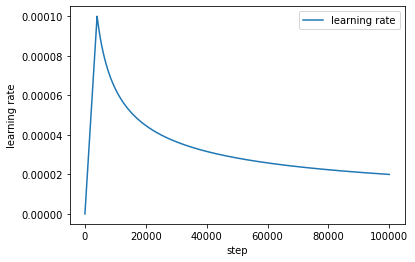

In [32]:
#learning_rateの推移を図で確認する。
import matplotlib.pyplot as plt
ls=[]
for step in range(1,100000):
    ls.append(get_learning_rate(step))
plt.plot(ls,label='learning rate')
plt.xlabel('step')
plt.ylabel('learning rate')
plt.legend()
plt.show()

In [33]:
with graph.as_default():
    # 元コード
    # sess = tf.Session()
    # sess.run(tf.global_variables_initializer())

    # TensorFlowのセッションとは、構築されたデータフローグラフの演算処理を
    # 実際に行うランタイムへのクライアントのこと。
    sess = tf.compat.v1.Session()

    #sess.runについてはよく分かっていない。
    sess.run(tf.compat.v1.global_variables_initializer())
    step = 0

In [34]:
with graph.as_default():
    for batch in batch_generator.get_batch(batch_size=batch_size):
        #batchには以下の形式(例)の辞書がyieldされる。
        # {'transformer/encoder_input:0':[122,4,56,7,8,0,0,0,0] ,
        # 'transformer/decoder_input:0':[3,56,66,100,0,0,0,0,0],
        # 'transformer/is_training:0': True}

        feed = {
            **batch,
            learning_rate: get_learning_rate(step + 1),
        }
        #batchの辞書にlearning_rate: get_learning_rate(step + 1)のkeyとvalueを追加している。
        #このlearning_rate は tf.compat.v1.placeholder(dtype=tf.float32, name='learning_rate'


        _, loss, acc, step, summary = sess.run( #stepはglobal_stepによってここで更新されている？
            [optimize_op, transformer.loss, transformer.acc, global_step, summary_op],
            feed_dict=feed
        )
        #sess.runの構文は、
        #run(fetches, feed_dict=None, options=None, run_metadata=None)
        #プレースホルダーに値を与えるには、evalメソッドのfeed_dict引数に辞書オブジェクトを与えるか（リスト2）、
        #セッションクラスで定義されているrunメソッドのfeed_dict引数を用いる。

        #build_graphの際にplaceholderの名前として
        #self.encoder_input = tf.compat.v1.placeholder(dtype=tf.int32, shape=[None, None], name='encoder_input')
        #などを定義しているので、feed_dict=feedによって、
        #placeholderのencoder_input, decoder_input, is_training, learning_rateの4つが与えられる。

        #fetchesはrunした際の1フィードでの（多分）それぞれの値を取得。
        #global_stepは自動更新される？？

        summary_writer.add_summary(summary, step)

        #print(step)

        if step % 100 == 0:
            print(f'{step}: loss: {loss},\t acc: {acc}')
            saver.save(sess, ckpt_path, global_step=step)
            # saver.saveの構文はsyntaxは以下の通り。
            # save(sess, save_path, global_step=None, latest_filename=None,
            # meta_graph_suffix='meta', write_meta_graph=True, write_state=True,
            # strip_default_attrs=False, save_debug_info=False)

0: loss: 8.409122467041016,	 acc: 0.0007867820677347481
100: loss: 8.077666282653809,	 acc: 0.057603687047958374


KeyboardInterrupt: 